In [118]:
import pandas_datareader.data as web
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import warnings
import sys, os
import seaborn as sns


## Helper Functions

In [119]:
temp_stdout = None

# Disable
def blockPrint():
    global temp_stdout
    temp_stdout = sys.stdout
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    global temp_stdout
    sys.stdout = temp_stdout

In [146]:
def get_opt_model(returns, max_p, max_q, metric="AIC"):
    min_metric = float('inf')
    opt_p_q = []
    metric_mat = np.zeros((max_p, max_q))
    for p in range(1, max_p+1):
        for q in range(1, max_p+1):
            model = arch_model(returns, p=p, q=q)
            model_fit = model.fit()
            if metric == "AIC":
                aic = model_fit.aic
                metric_mat[p-1, q-1] = round(aic, 1)
                if aic < min_metric:
                    min_metric = aic
                    opt_p_q = [p, q]
            elif metric == "BIC":
                bic = model_fit.bic
                metric_mat[p-1, q-1] = round(bic, 1)
                if bic < min_metric:
                    min_metric = bic
                    opt_p_q = [p, q]
                    
    return opt_p_q[0], opt_p_q[1], metric_mat

In [121]:
def heatmap(mat, model_type, metric):
    plt.clf()
    heatmap = sns.heatmap(mat, 
                          # cmap=color_scheme,
                          xticklabels=range(1, mat.shape[0]+1),
                          yticklabels=range(1, mat.shape[0]+1), 
                          vmin=np.min(mat), 
                          vmax=np.max(mat))
    heatmap.set_title(f"{metric} Heatmap")
    heatmap.set(xlabel = f"{model_type} q values", ylabel = "GARCH p values")
    plt.show()

In [178]:
def rolling_predictions(returns, opt_p, opt_q):
    warnings.filterwarnings('ignore')
    rolling_predictions = []
    test_size = 365*5

    for i in range(test_size):
        train = returns[:-(test_size-i)]
        model = arch_model(train, p=opt_p, q=opt_q)
        model_fit = model.fit(disp='off')
        pred = model_fit.forecast(horizon=1)
        rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
        
    rolling_predictions = pd.Series(rolling_predictions, index=returns.index[-365*5:])

    plt.figure(figsize=(10,4))
    true, = plt.plot(returns[-365*5:])
    preds, = plt.plot(rolling_predictions)
    plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
    plt.legend(['Returns', 'Predicted Volatility'], fontsize=16)
    
    return rolling_predictions

In [190]:
def long_prediction(model, returns, num_test_days, opt_p, opt_q, rolling_preds):
    
    # THOUGHTS:
    # i don't think this is dont correctly since the 30-day and rolling forecast yield the same volatility
    # not sure what we are supposed to compare the 30-day forecast with?
    # how do we calculate the RMSE and MAE? like what are we using as a comparison volatility? 
    # if i'm not mistaken, the article from the link below says that volatility can't be measured point-wise
    # found this (not sure if its helpful): https://stats.stackexchange.com/questions/205562/evaluate-forecasting-ability-of-garch-models-with-rmse-and-mae 
    # quote from the link above: "The problem with such error metrics is that volatility is not an observable thing, and it depends on the model. 
    # Hence the error is not something well defined (compare what with what?)"

    
    train = returns[:-num_test_days]
    model = arch_model(train, p=opt_p, q=opt_q)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=num_test_days)
    test_dates = returns.index[len(returns)-num_test_days:]
    pred = pd.Series(np.sqrt(pred.variance.values[-1,:]), index=test_dates)
    plt.figure(figsize=(10,4))
    plt.plot(rolling_preds[len(returns)-num_test_days:], label=f"rolling prediction", linewidth=3)
    plt.plot(pred, label=f"{num_test_days}-day prediction", linewidth=1)
    plt.legend(loc ="lower left")
    plt.title(f'Volatility Prediction: {num_test_days} Days vs Rolling Prediction', fontsize=20)

In [183]:
def train_metrics(returns, model_type, metric, max_p, max_q):
    blockPrint()
    opt_p, opt_q, aic_mat = get_opt_model(returns, max_p, max_q, metric)
    opt_model = arch_model(returns, p=opt_p, q=opt_q, vol=model_type).fit()
    enablePrint()
    
    print(f"{metric} matrix: \n{aic_mat}")
    heatmap(aic_mat, model_type, metric)

    print(f"\n--- {model_type}({opt_p}, {opt_q}) ---")
    print(opt_model.summary())
    
    rolling_preds = rolling_predictions(returns, opt_p, opt_q)
    
    long_prediction(opt_model, returns, 30, opt_p, opt_q, rolling_preds)

# __________________________________________________________

## Load S&P 500 Data

In [168]:
start = datetime(2012, 11, 11)
end = datetime(2022, 11, 11)
spy = web.DataReader('SPY', 'yahoo', start=start, end=end)
returns = 100 * spy.Close.pct_change().dropna()
returns

Date
2012-11-13   -0.347155
2012-11-14   -1.349881
2012-11-15   -0.169202
2012-11-16    0.493735
2012-11-19    2.023913
                ...   
2022-11-07    0.956558
2022-11-08    0.539541
2022-11-09   -2.060208
2022-11-10    5.495415
2022-11-11    0.967850
Name: Close, Length: 2518, dtype: float64

## Plot Data

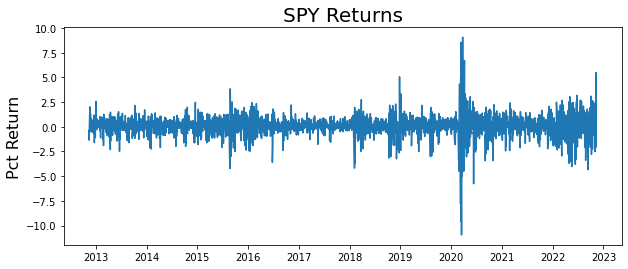

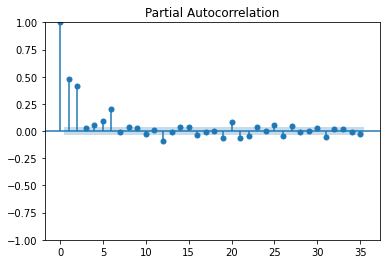

In [126]:
plt.figure(figsize=(10,4))
plt.plot(returns)
plt.ylabel('Pct Return', fontsize=16)
plt.title('SPY Returns', fontsize=20)
plot_pacf(returns**2)
plt.show()

## Analyze Data: GARCH

### GARCH AIC & BIC

AIC matrix: 
[[6261.5 6263.5 6265.5 6267.5 6269.5]
 [6263.2 6264.3 6266.3 6268.3 6270.3]
 [6264.4 6266.4 6267.4 6269.4 6270.6]
 [6266.4 6265.4 6267.  6268.8 6268.1]
 [6268.4 6267.4 6269.  6270.8 6270.1]]


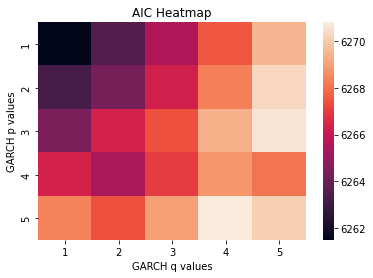


--- GARCH(1, 1) ---
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3126.76
Distribution:                  Normal   AIC:                           6261.52
Method:            Maximum Likelihood   BIC:                           6284.84
                                        No. Observations:                 2518
Date:                Wed, Dec 07 2022   Df Residuals:                     2517
Time:                        00:20:13   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0855  1.399e-02      6.111

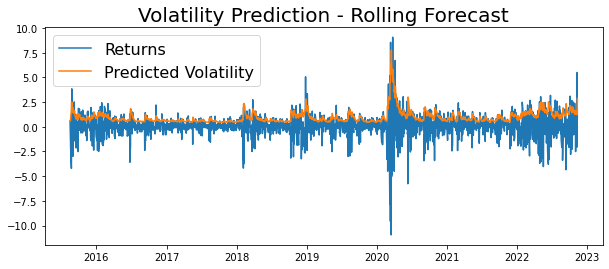

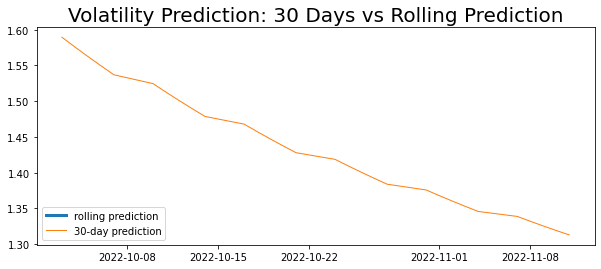

In [191]:
train_metrics(returns=returns, model_type="GARCH", metric="AIC", max_p=5, max_q=5)

BIC matrix: 
[[6284.8 6292.7 6300.5 6308.3 6316.2]
 [6292.3 6299.3 6307.1 6314.9 6322.7]
 [6299.4 6307.2 6314.1 6321.9 6328.9]
 [6307.3 6312.  6319.4 6327.1 6332.2]
 [6315.1 6319.9 6327.3 6334.9 6340. ]]


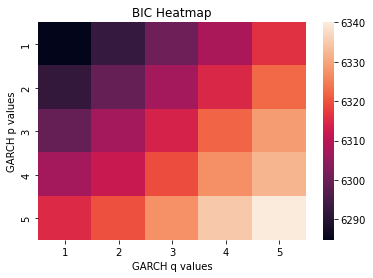


--- GARCH(1, 1) ---
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3126.76
Distribution:                  Normal   AIC:                           6261.52
Method:            Maximum Likelihood   BIC:                           6284.84
                                        No. Observations:                 2518
Date:                Tue, Dec 06 2022   Df Residuals:                     2517
Time:                        22:47:22   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0855  1.399e-02      6.111

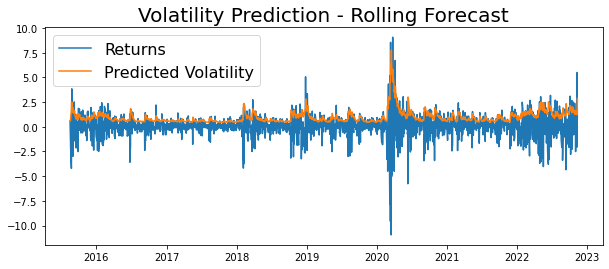

In [159]:
train_metrics(returns=returns, model_type="GARCH", metric="BIC", max_p=5, max_q=5)

### EGARCH AIC & BIC

AIC matrix: 
[[6261.5 6263.5 6265.5 6267.5 6269.5]
 [6263.2 6264.3 6266.3 6268.3 6270.3]
 [6264.4 6266.4 6267.4 6269.4 6270.6]
 [6266.4 6265.4 6267.  6268.8 6268.1]
 [6268.4 6267.4 6269.  6270.8 6270.1]]


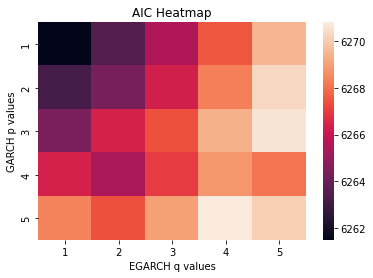


--- EGARCH(1, 1) ---
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -3137.23
Distribution:                  Normal   AIC:                           6282.47
Method:            Maximum Likelihood   BIC:                           6305.79
                                        No. Observations:                 2518
Date:                Tue, Dec 06 2022   Df Residuals:                     2517
Time:                        21:26:05   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0957  1.435e-02      6.66

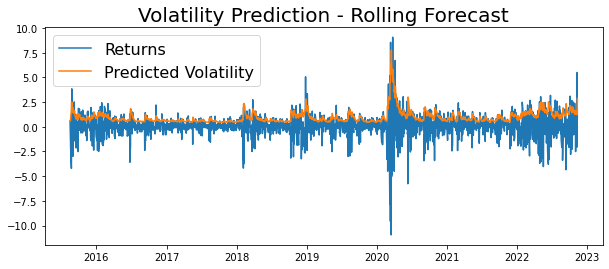

In [145]:
train_metrics(returns=returns, model_type="EGARCH", metric="AIC", max_p=5, max_q=5)

BIC matrix: 
[[6284.8 6292.7 6300.5 6308.3 6316.2]
 [6292.3 6299.3 6307.1 6314.9 6322.7]
 [6299.4 6307.2 6314.1 6321.9 6328.9]
 [6307.3 6312.  6319.4 6327.1 6332.2]
 [6315.1 6319.9 6327.3 6334.9 6340. ]]


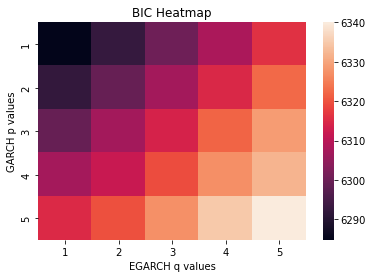


--- EGARCH(1, 1) ---
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -3137.23
Distribution:                  Normal   AIC:                           6282.47
Method:            Maximum Likelihood   BIC:                           6305.79
                                        No. Observations:                 2518
Date:                Tue, Dec 06 2022   Df Residuals:                     2517
Time:                        22:48:53   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0957  1.435e-02      6.66

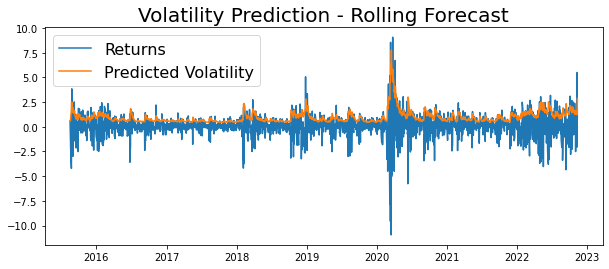

In [160]:
train_metrics(returns=returns, model_type="EGARCH", metric="BIC", max_p=5, max_q=5)

# __________________________________________________________

## Load S&P 500 Futures Data

In [165]:
df_futures = pd.read_csv("FuturesData.csv")
df_futures = df_futures[['Date', 'Price', 'Change %']]
# df_futures['Price'] = [float(x.replace(',', '')) for x in df_futures['Price']]
df_futures['Change %'] = [float(x.strip('%')) for x in df_futures['Change %']]
df_futures['Date'] = pd.to_datetime(df_futures['Date'])
returns_futures = df_futures["Change %"]
returns_futures.index = df_futures['Date']
returns_futures = returns_futures.sort_index(ascending=True)
returns_futures

Date
2012-11-12    0.18
2012-11-13   -0.53
2012-11-14   -1.31
2012-11-15   -0.13
2012-11-16    0.63
              ... 
2022-11-30    3.01
2022-12-01    0.01
2022-12-02   -0.15
2022-12-05   -1.77
2022-12-06   -1.46
Name: Change %, Length: 2563, dtype: float64

## Visualize Futures Data

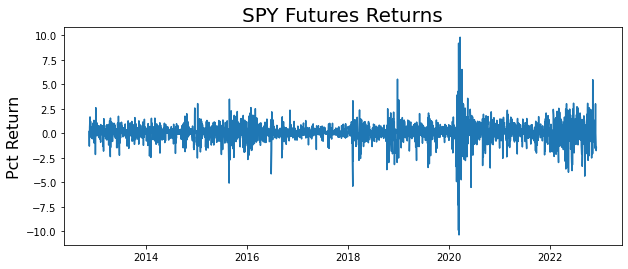

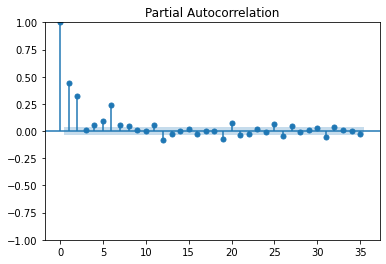

In [155]:
plt.figure(figsize=(10,4))
plt.plot(returns_futures)
plt.ylabel('Pct Return', fontsize=16)
plt.title('SPY Futures Returns', fontsize=20)
plot_pacf(returns_futures**2)
plt.show()

## Analyze Futures Data: GARCH

### GARCH AIC & BIC

AIC matrix: 
[[6297.3 6299.3 6301.3 6303.3 6305.3]
 [6272.5 6274.2 6275.5 6276.2 6278.2]
 [6274.5 6275.4 6276.5 6277.3 6279.3]
 [6276.5 6277.4 6278.1 6276.4 6278.4]
 [6278.5 6279.4 6280.1 6278.4 6280.4]]


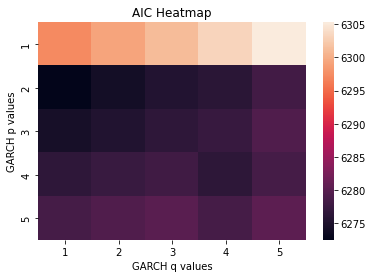


--- GARCH(2, 1) ---
                     Constant Mean - GARCH Model Results                      
Dep. Variable:               Change %   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3131.25
Distribution:                  Normal   AIC:                           6272.51
Method:            Maximum Likelihood   BIC:                           6301.75
                                        No. Observations:                 2563
Date:                Tue, Dec 06 2022   Df Residuals:                     2562
Time:                        22:28:25   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0900  1.261e-02      7.132

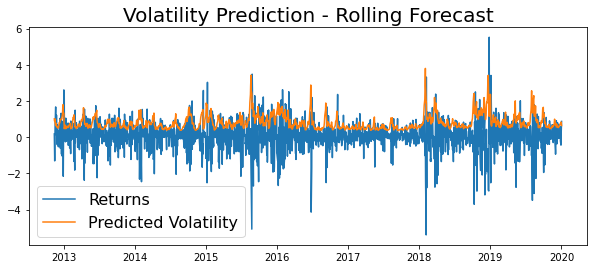

In [156]:
train_metrics(returns=returns_futures, model_type="GARCH", metric="AIC", max_p=5, max_q=5)

BIC matrix: 
[[6320.7 6328.5 6336.4 6344.2 6352.1]
 [6301.8 6309.3 6316.4 6323.  6330.9]
 [6309.6 6316.3 6323.3 6330.  6337.8]
 [6317.4 6324.2 6330.7 6334.9 6342.8]
 [6325.3 6332.  6338.5 6342.8 6350.6]]


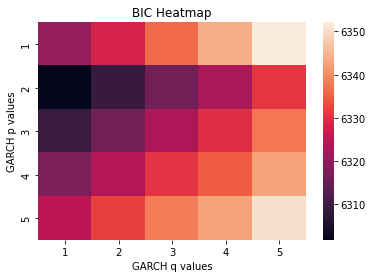


--- GARCH(2, 1) ---
                     Constant Mean - GARCH Model Results                      
Dep. Variable:               Change %   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3131.25
Distribution:                  Normal   AIC:                           6272.51
Method:            Maximum Likelihood   BIC:                           6301.75
                                        No. Observations:                 2563
Date:                Tue, Dec 06 2022   Df Residuals:                     2562
Time:                        22:51:07   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0900  1.261e-02      7.132

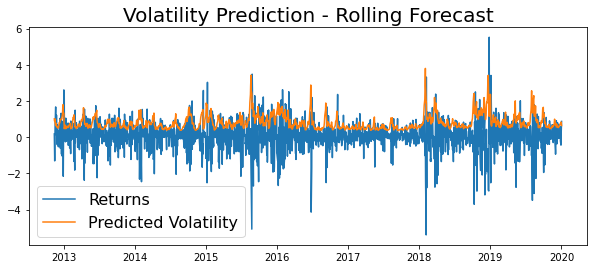

In [162]:
train_metrics(returns=returns_futures, model_type="GARCH", metric="BIC", max_p=5, max_q=5)

### EGARCH AIC & BIC

AIC matrix: 
[[6297.3 6299.3 6301.3 6303.3 6305.3]
 [6272.5 6274.2 6275.5 6276.2 6278.2]
 [6274.5 6275.4 6276.5 6277.3 6279.3]
 [6276.5 6277.4 6278.1 6276.4 6278.4]
 [6278.5 6279.4 6280.1 6278.4 6280.4]]


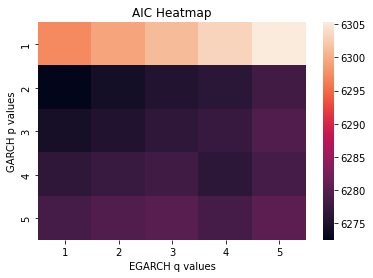


--- EGARCH(2, 1) ---
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:               Change %   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -3123.19
Distribution:                  Normal   AIC:                           6256.38
Method:            Maximum Likelihood   BIC:                           6285.62
                                        No. Observations:                 2563
Date:                Tue, Dec 06 2022   Df Residuals:                     2562
Time:                        22:52:01   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0922  1.225e-02      7.52

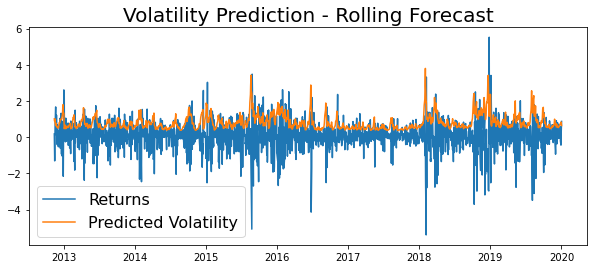

In [163]:
train_metrics(returns=returns_futures, model_type="EGARCH", metric="AIC", max_p=5, max_q=5)

BIC matrix: 
[[6320.7 6328.5 6336.4 6344.2 6352.1]
 [6301.8 6309.3 6316.4 6323.  6330.9]
 [6309.6 6316.3 6323.3 6330.  6337.8]
 [6317.4 6324.2 6330.7 6334.9 6342.8]
 [6325.3 6332.  6338.5 6342.8 6350.6]]


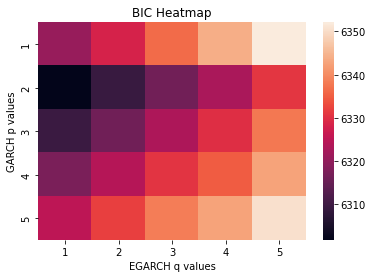


--- EGARCH(2, 1) ---
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:               Change %   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -3123.19
Distribution:                  Normal   AIC:                           6256.38
Method:            Maximum Likelihood   BIC:                           6285.62
                                        No. Observations:                 2563
Date:                Tue, Dec 06 2022   Df Residuals:                     2562
Time:                        22:52:39   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0922  1.225e-02      7.52

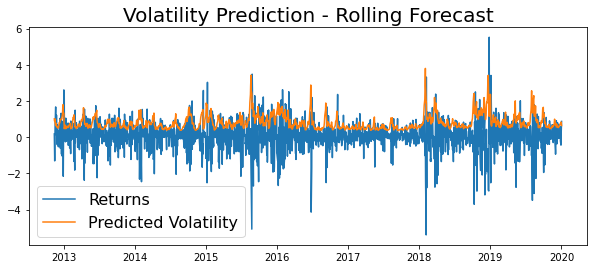

In [164]:
train_metrics(returns=returns_futures, model_type="EGARCH", metric="BIC", max_p=5, max_q=5)